In [2]:
# =============================
# 📌 1. Setup & Imports
# =============================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

In [3]:
train_data_path='train_data.csv'
test_data_path='test_data.csv'


In [4]:
# Load with header if columns are labeled
train_data = pd.read_csv(train_data_path, header=0)
test_data = pd.read_csv(test_data_path, header=0)

X_train = train_data.iloc[:, 2:]
y_train = train_data.iloc[:, 1]
X_valid = test_data.iloc[:, 2:]
y_valid = test_data.iloc[:, 1]

# Convert to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_valid = X_valid.apply(pd.to_numeric, errors='coerce').fillna(0)
y_train = pd.to_numeric(y_train, errors='coerce').fillna(0)
y_valid = pd.to_numeric(y_valid, errors='coerce').fillna(0)
patient_ids = test_data.iloc[:, 0]
# DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)


In [5]:
y_valid.head()

0    0
1    0
2    0
3    1
4    0
Name: pcr, dtype: int64

In [6]:
# =============================
# 🔧 3. Define DMatrix and parameters
# =============================
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)


params = {
    "objective": "binary:logistic",
    "eta": 0.1,
    "max_depth": 8,
    "eval_metric": "auc",
    "tree_method": "hist",
    "nthread": 16
}

num_boost_round = 100


In [7]:
# =============================
# 🧠 4. Train Model
# =============================
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round
)

# Save model (optional)
bst.save_model("model_trained.json")


In [8]:
# Load model and predict
#model_path = "model_trained.json"
#model_path="./results/centralized_model/same_with_fl/centralized_xgbt.json"
model_path ="./local_models/site-4_best_model.json"
#model_path ="site-4_best_model.json"
#model_path = "xgboost_model.json"
bst = xgb.Booster(params, model_file=model_path)
#y_pred = bst.predict(dvalid)


In [9]:
# =============================
# 📊 5. Validate Model
# =============================
y_pred = bst.predict(dvalid)
auc = roc_auc_score(y_valid, y_pred)

# Balanced Accuracy at fixed threshold (e.g., 0.2)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)
balanced_acc = balanced_accuracy_score(y_valid, y_pred_binary)

print(f"AUC: {auc:.4f}")
print(f"Balanced Accuracy @ {threshold:.2f} threshold: {balanced_acc:.4f}")


AUC: 0.6947
Balanced Accuracy @ 0.50 threshold: 0.5925


In [10]:
# =============================
# 🧪 6. Find Best Threshold for Balanced Accuracy
# =============================
thresholds = np.linspace(0, 1, 101)
best_thresh = 0
best_bal_acc = 0

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    bal_acc = balanced_accuracy_score(y_valid, y_pred_binary)
    if bal_acc > best_bal_acc:
        best_bal_acc = bal_acc
        best_thresh = t

print(f"Best Threshold: {best_thresh:.4f}")
print(f"Best Balanced Accuracy: {best_bal_acc:.4f}")


Best Threshold: 0.2200
Best Balanced Accuracy: 0.6697


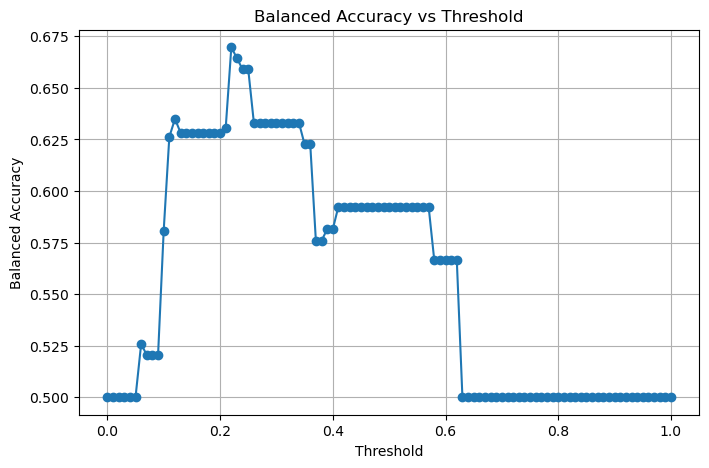

In [11]:
# =============================
# 📈 7. Optional: Plot Balanced Accuracy vs Threshold
# =============================
bal_acc_list = [balanced_accuracy_score(y_valid, (y_pred >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(8, 5))
plt.plot(thresholds, bal_acc_list, marker='o')
plt.title("Balanced Accuracy vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.grid(True)
plt.show()


In [12]:
# ✅ Save predictions with patient IDs
output_df = pd.DataFrame({
    "patient_id": patient_ids,
    "true_label": y_valid,
    "predicted_prob": y_pred
})
output_df.to_csv("predictions_with_ids.csv", index=False)
print("Saved predictions to predictions_with_ids.csv")


Saved predictions to predictions_with_ids.csv


In [13]:
"""
scoring_prediction.py

This script evaluates classification predictions (Task 2) for the MAMA-MIA Challenge.
It computes performance and fairness metrics, generates subgroup-wise confusion matrices,
and produces a radar plot to visualize fairness disparities.

Main functionalities:
- Compute Balanced Accuracy as the main performance metric.
- Evaluate fairness using Equalized Odds (True Positive Rate and False Positive Rate disparities)
  across multiple subgroups (e.g., age, menopausal status, breast density).
- Plot and save confusion matrices for each subgroup.
- Generate a radar chart summarizing fairness disparities across selected variables.
- Print subgroup-specific performance metrics including Balanced Accuracy and AUC.

Expected Inputs:
- Clinical and imaging metadata (Excel file with 'dataset_info' sheet)
- Ground truth and predicted PCR labels (simulated with random predictions in this template)
Note:
Replace the placeholder prediction generation with your model’s predicted probabilities and binary labels.

Expected Outputs:
- CSV file with subgroup predictions
- Confusion matrix plots for each fairness variable
- Radar plot showing fairness disparities
- Printed metrics for overall and subgroup-level performance

Author: Lidia Garrucho, Universitat de Barcelona
Date: April 2025
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score

# ----------------------------
# Utility Functions
# ----------------------------

def plot_confusion_matrices(df, group_var, y_true_col='pcr', y_pred_col='pcr_pred', save_path=None):
    """Plot confusion matrices for each group in the fairness variable."""
    groups = df[group_var].dropna().unique()
    num_groups = len(groups)
    cols = num_groups
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()
    # The order of the age groups should be from '0-40' to '71+'
    if group_var == 'age':
        age_order = ['0-40', '41-50', '51-60', '61-70', '71+']
        groups = sorted(groups, key=lambda x: age_order.index(x) if x in age_order else len(age_order))
    elif group_var == 'breast_density':
        density_order = ['a', 'b', 'c', 'd']
        groups = sorted(groups, key=lambda x: density_order.index(x) if x in density_order else len(density_order))
    elif group_var == 'menopausal_status':
        menopause_order = ['premenopause', 'postmenopause']
        groups = sorted(groups, key=lambda x: menopause_order.index(x) if x in menopause_order else len(menopause_order))
    for i, group in enumerate(groups):
        subset = df[df[group_var] == group]
        y_true = subset[y_true_col].astype(int)
        y_pred = subset[y_pred_col].astype(int)
        if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
            axes[i].set_visible(False)
            continue
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={"size": 14})
        axes[i].set_title(f'{group_var} = {group}', fontsize=16)
        axes[i].set_xlabel('Predicted', fontsize=14)
        axes[i].set_ylabel('True', fontsize=14)
        axes[i].tick_params(axis='both', labelsize=14)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_fairness_radar(equalized_odds_disparities, output_path):
    """Plot a radar chart of Equalized Odds disparities across fairness variables."""
    variables = list(equalized_odds_disparities.keys())
    disparities = list(equalized_odds_disparities.values())
    
    # Radar plot setup
    angles = np.linspace(0, 2 * np.pi, len(variables), endpoint=False).tolist()
    disparities += disparities[:1]  # Cierre del radar
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, disparities, 'o-', linewidth=2, label='Equalized Odds Disparity')
    ax.fill(angles, disparities, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), variables)
    ax.set_title('Fairness Disparity (TPR+FPR)')
    ax.set_ylim(0, max(disparities) + 0.1)
    ax.grid(True)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

def print_subgroup_metrics(df, fairness_variables):
    """Print balanced accuracy and AUC for each subgroup."""
    for var in fairness_variables:
        print(f'\nSubgroup metrics by {var}')
        for group_name, group in df.groupby(var):
            y_true = group['pcr'].astype(int)
            y_pred = group['pcr_pred'].round().astype(int)
            y_prob = group['pcr_pred']
            try:
                bacc = balanced_accuracy_score(y_true, y_pred)
                auc = roc_auc_score(y_true, y_prob)
                print(f'  {group_name}: Balanced Acc = {bacc:.3f}, AUC = {auc:.3f} (Samples: {len(group)})')
            except ValueError:
                print(f'  {group_name}: Not enough samples for AUC')



In [14]:
    # Settings
alpha = 0.5  # Weight for balancing performance and fairness
selected_fairness_variables = ['age', 'menopause','manufacturer','site_center']
#selected_fairness_variables = ['site_center']
# The challenge will also evaluate the breast density variable, but it is not included in all the training data

# Define paths (modify as needed)
data_dir = './'  # Path to the data directory
clinical_data_xlsx = 'clinical_and_imaging_info.xlsx' # Path to the clinical data
output_csv = f'{data_dir}/results_task2.csv'
output_plots_dir = f'{data_dir}/plots'

# Read clinical data and get the fairness groups
clinical_df = pd.read_excel(clinical_data_xlsx, sheet_name='dataset_info')
clinical_df['site_center'] = clinical_df['patient_id'].str.split('_').str[0]
# For fairness_varibles_df, we will drop all the clinical_df columns except the selected_fairness_variables and patient_id
fairness_varibles_df = clinical_df[['patient_id', 'pcr'] + selected_fairness_variables]
# Modify age column values mapping them by age groups
fairness_varibles_df['age'] = pd.cut(fairness_varibles_df['age'], bins=[0, 40, 50, 60, 70, 100], labels=['0-40', '41-50', '51-60', '61-70', '71+'])
# Clean menopausal status
fairness_varibles_df['menopause'] = (
    fairness_varibles_df['menopause']
    .fillna('unknown')
    .str.lower()
    .apply(lambda x: 'pre' if 'peri' in x or 'pre' in x else ('post' if 'post' in x else x))
)

# Create output directories if they do not exist
os.makedirs(output_plots_dir, exist_ok=True)

pred_scores = pd.read_csv('predictions_with_ids.csv')
# Convert both to lowercase (or uppercase) for consistency
fairness_varibles_df['patient_id'] = fairness_varibles_df['patient_id'].str.lower()  # Ensure lowercase
pred_scores['patient_id'] = pred_scores['patient_id'].str.lower()  # Ensure lowercase

# Merge (inner join keeps only matching rows)
merged_df = pd.merge(
    fairness_varibles_df,
    pred_scores[['patient_id', 'predicted_prob']],
    on='patient_id',
    how='inner'
)

# Apply threshold and convert to binary (0/1)
t=0.4800
merged_df['pcr_pred'] = (merged_df['predicted_prob'] > t).astype(int)
fairness_varibles_df=merged_df
fairness_varibles_df.to_csv(output_csv, index=False)

# Score performance
y_true = fairness_varibles_df['pcr'].fillna(0).astype(int)
y_pred = fairness_varibles_df['pcr_pred'].fillna(0).astype(int)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f'Average Balanced Accuracy: {balanced_accuracy:.4f}')
performance_score = balanced_accuracy

# Fairness analysis
equalized_odds_disparities = {}


Average Balanced Accuracy: 0.5925


/tmp/ipykernel_3066/3278921610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_varibles_df['age'] = pd.cut(fairness_varibles_df['age'], bins=[0, 40, 50, 60, 70, 100], labels=['0-40', '41-50', '51-60', '61-70', '71+'])
/tmp/ipykernel_3066/3278921610.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fairness_varibles_df['menopause'] = (
/tmp/ipykernel_3066/3278921610.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [15]:
for var in selected_fairness_variables:
    groups = fairness_varibles_df.groupby(var)
    tpr, fpr = {}, {}

    for i, (_, group) in enumerate(groups):
        yt = group['pcr'].astype(int)
        yp = group['pcr_pred'].astype(int)
        try:
            tn, fp_, fn, tp = confusion_matrix(yt, yp).ravel()
            tpr[i] = tp / (tp + fn) if (tp + fn) else 0
            fpr[i] = fp_ / (fp_ + tn) if (fp_ + tn) else 0
        except ValueError:
            tpr[i], fpr[i] = 0, 0

    disparity = max(tpr.values()) - min(tpr.values()) + max(fpr.values()) - min(fpr.values())
    equalized_odds_disparities[var] = disparity


/tmp/ipykernel_3066/3033554862.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = fairness_varibles_df.groupby(var)


Fairness Score: 0.5509
Ranking Score: 0.5717

Subgroup metrics by age
  0-40: Balanced Acc = 0.625, AUC = 0.625 (Samples: 77)
  41-50: Balanced Acc = 0.600, AUC = 0.600 (Samples: 120)
  51-60: Balanced Acc = 0.558, AUC = 0.558 (Samples: 78)
  61-70: Balanced Acc = 0.542, AUC = 0.542 (Samples: 24)
  71+: Balanced Acc = 0.625, AUC = 0.625 (Samples: 6)

Subgroup metrics by menopause
  post: Balanced Acc = 0.602, AUC = 0.602 (Samples: 62)
  pre: Balanced Acc = 0.607, AUC = 0.607 (Samples: 130)
  unknown: Balanced Acc = 0.552, AUC = 0.552 (Samples: 114)

Subgroup metrics by manufacturer
  GE: Balanced Acc = 0.574, AUC = 0.574 (Samples: 141)
  Philips: Balanced Acc = 0.500, AUC = 0.500 (Samples: 25)
  SIEMENS: Balanced Acc = 0.613, AUC = 0.613 (Samples: 140)

Subgroup metrics by site_center
  DUKE: Balanced Acc = 0.684, AUC = 0.684 (Samples: 91)
  ISPY1: Balanced Acc = 0.536, AUC = 0.536 (Samples: 67)
  ISPY2: Balanced Acc = 0.547, AUC = 0.547 (Samples: 131)
  NACT: Balanced Acc = 0.500, AUC

/tmp/ipykernel_3066/175139141.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group in df.groupby(var):


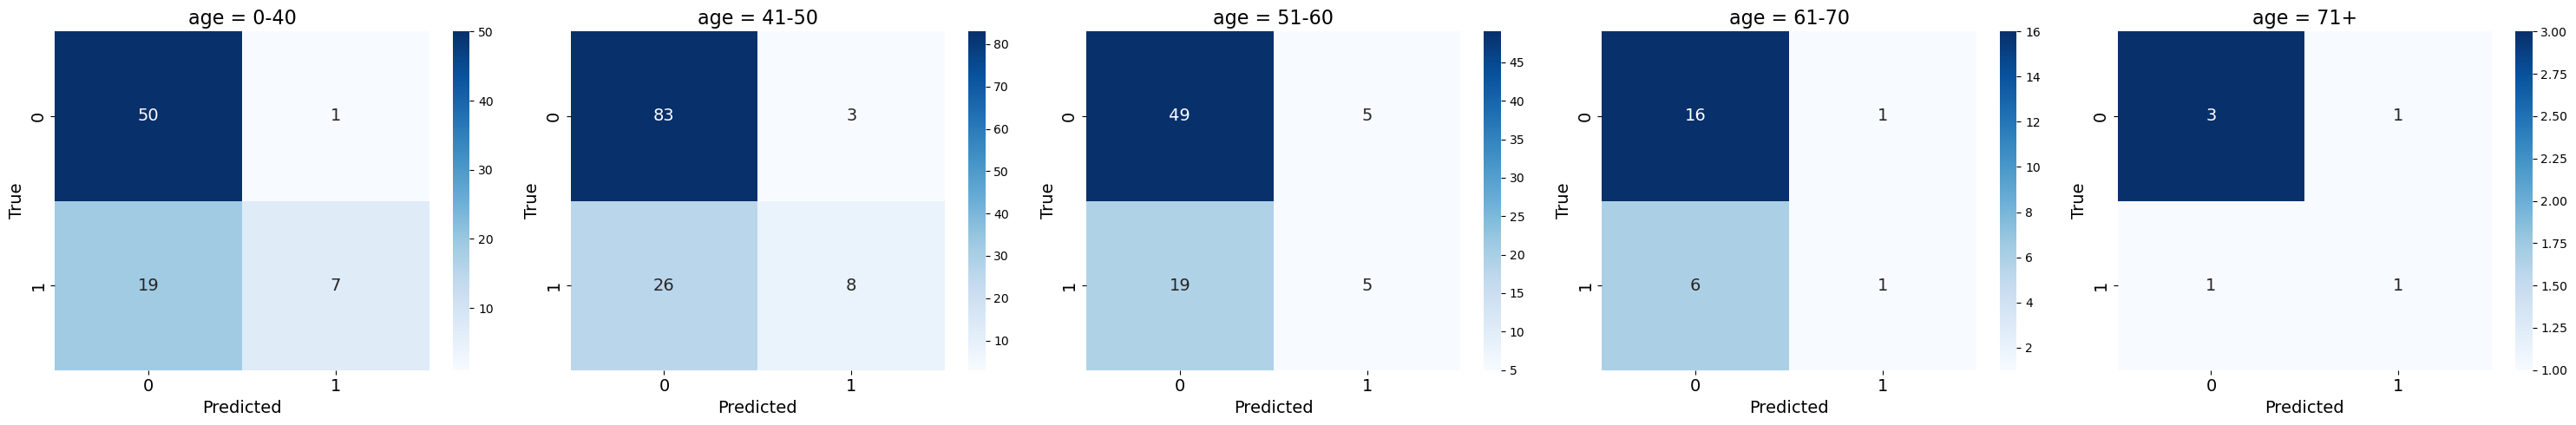

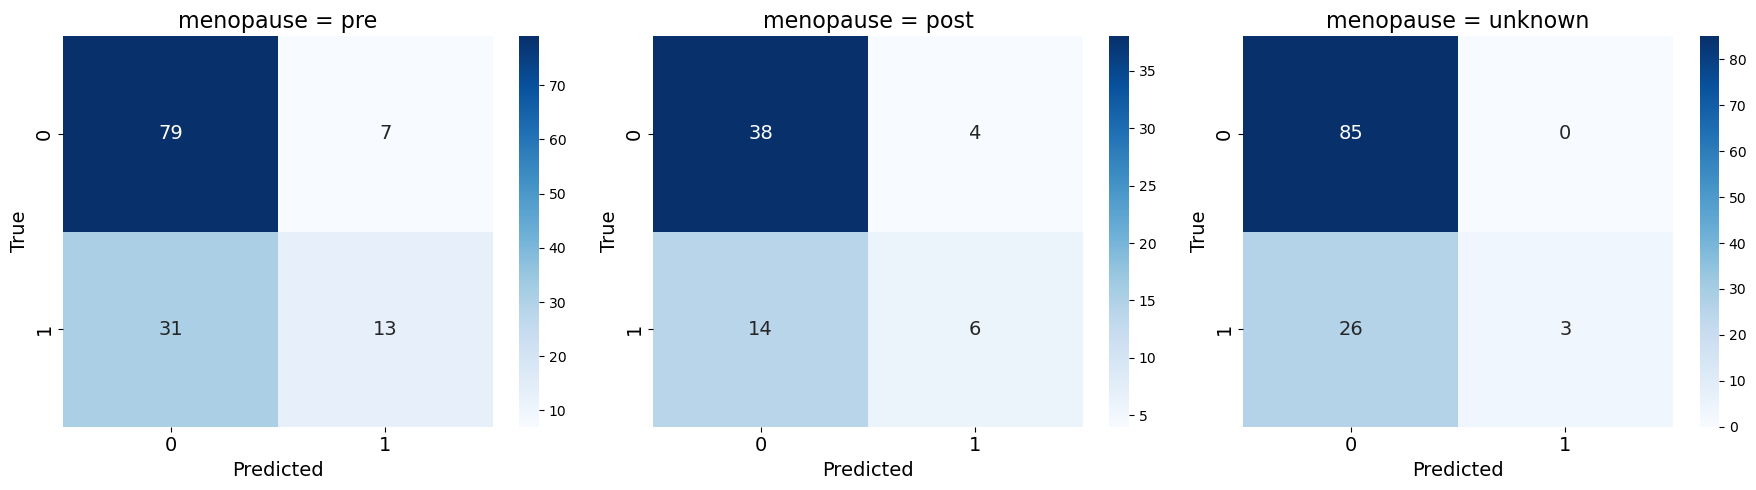

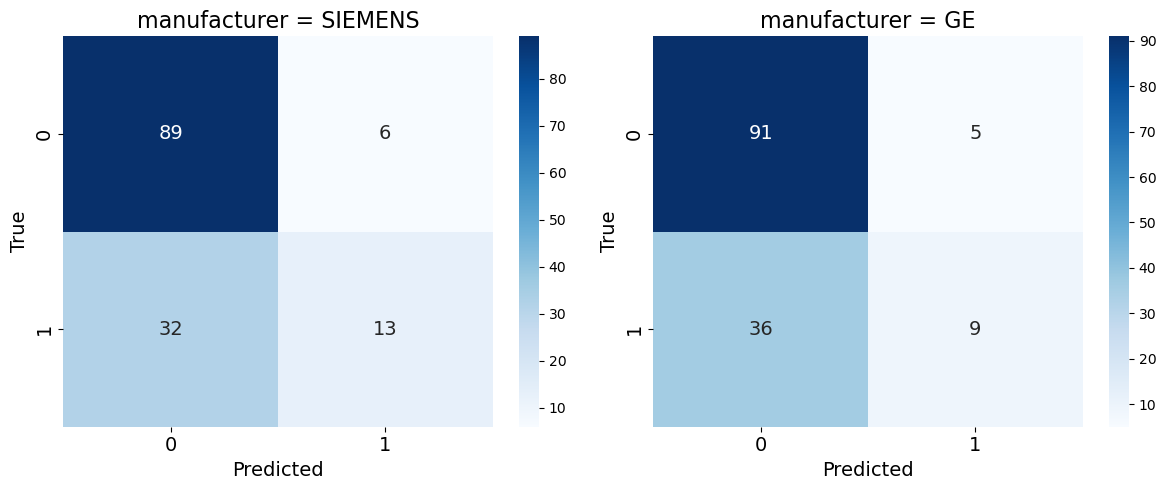

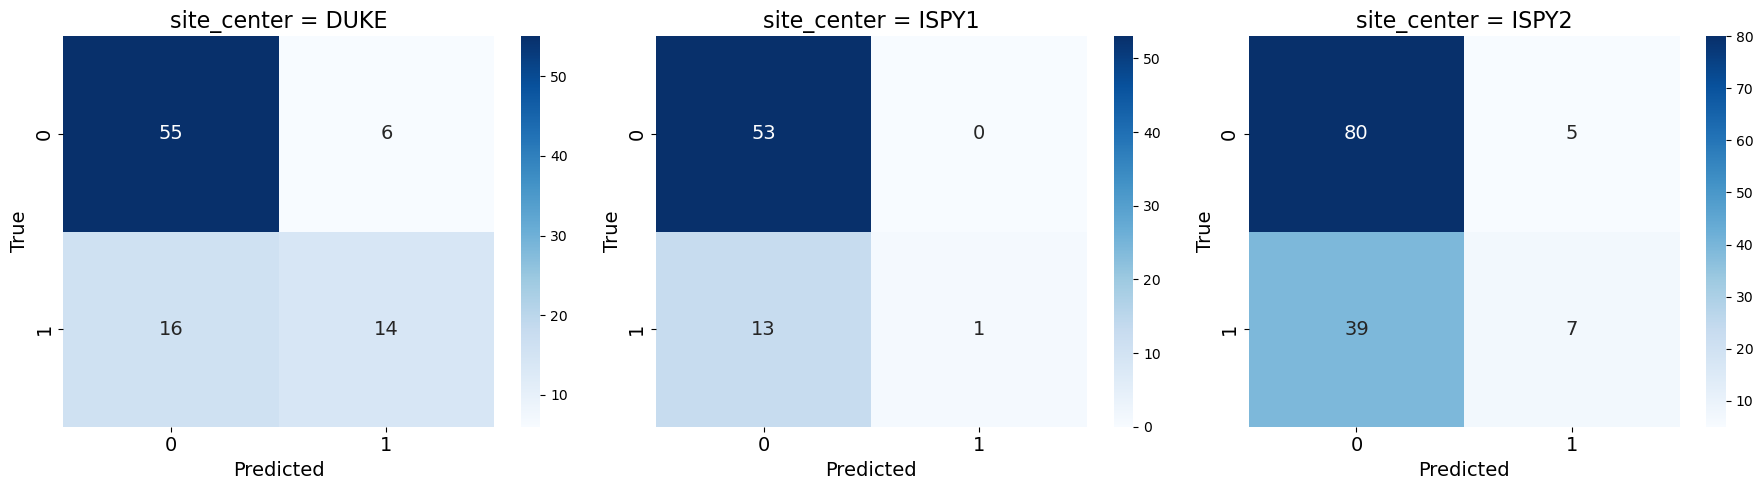

In [16]:
fairness_score = np.mean(list(equalized_odds_disparities.values()))
fairness_score = np.clip(fairness_score, 0, 1)
ranking_score = (1 - alpha) * performance_score + alpha * (1 - fairness_score)

print(f'Fairness Score: {1 - fairness_score:.4f}')
print(f'Ranking Score: {ranking_score:.4f}')

# Print subgroup metrics
print_subgroup_metrics(fairness_varibles_df, selected_fairness_variables)

# Generate plots
radar_plot_path = os.path.join(output_plots_dir, 'radar_fairness_disparities.png')
plot_fairness_radar(equalized_odds_disparities, radar_plot_path)

for var in selected_fairness_variables:
    plot_confusion_matrices(
        fairness_varibles_df, group_var=var,
        save_path=os.path.join(output_plots_dir, f'cm_by_{var}.png')
    )